Advanced Likelihood
===================
*Jeremy S. Perkins, FSSC*

Fit Verification
----------------

Most of the time, your initial fit will not converge.  This can manifest in several ways:

* It will say it didn't converge,
* It will crash (this is annoying),
* It will fail silently (this is also annoying).

When this happens, your fit is probably not correct and the errors are not accurate.  This is a bad thing and can lead to incorrect science results.  You don't want this.  

## How do I fix this?

1. The culprit is usually a parameter (or parameters) in the model that reach the limits set in the XML file. If this happens the minimizer cannot reach the formal minimum, and hence cannot calculate the curvature. 

    * Often the problem is with spectral shape parameters (PL index etc..), so simply freezing the shape of all spectral parameters to their values from the full time period (and certainly for weaker background sources) may solve the problem (this could introduce errors, so be careful if you have variable sources).

    * Weak background sources are more likely to cause problems, so you could consider just freezing them completely (or removing them from the model). For example a background source from the catalog that is detected at TS~=25 in 2 years could cause convergence problems in a 1-month light curve, where it will often not be detectable at all.

2. If there are no parameters at their limits, then increasing the overall convergence tolerance may help - try using a value of 1E-8 for the absolute tolerance.

3. If that doesn't help then try to systematically simplify the model. Progressively freeze all sources, starting with those at the edge of the ROI in and moving in until you get a model simple enough for the minimizer to work reliably. For example if you are using a 10 degree ROI, you could start by freezing all background sources further than 7 degrees from the source of interest, and move to 5 degrees if that doesn't solve the problem.

Also, check and make sure there aren't any bright pulsars in your ROI. They might need to be gated. It's also really difficult to get convergence at low energies (100 - 200 MeV) so you could restrict your fit to above 200 (or 300 MeV).

## How do I check for convergence?

Glad you asked, if you're using python, you can query the optimizer directly this way (using our little data set as an example).


In [1]:
%matplotlib inline
from UnbinnedAnalysis import *
import numpy as np
import matplotlib.pylab as plt

In [2]:
obs = UnbinnedObs(eventFile='3C279_filtered_gti.fits', 
                  scFile='L1405221252264C652E7F67_SC00.fits', 
                  expMap='3C279_expmap.fits',
                  expCube='3C279_ltcube.fits',
                  irfs='P7REP_SOURCE_V15')

In [3]:
analysis = UnbinnedAnalysis(obs,srcModel='3C279_input_model.xml', optimizer='NEWMINUIT')

Now, you have to create a logLike object (instead of having the fit routine create one on the fly) so we can access it later.

In [4]:
likeObj = pyLike.NewMinuit(analysis.logLike)

And then, when you do the fit, you pass that object to the fit function so it will use that one.

In [5]:
analysis.fit(covar=True,optObject=likeObj)

815515.8994541339

Now we can check out if the fit converged..

In [6]:
likeObj.getRetCode()

0

If this isn't 0 (for Minuit and NewMinuit at least) than you've got a problem and you need to work on your fit.

In [7]:
analysis2 = UnbinnedAnalysis(obs,srcModel='3C279_input_model.xml', optimizer='MINUIT')

In [8]:
likeObj2 = pyLike.Minuit(analysis2.logLike)

In [9]:
analysis2.fit(covar=True, optObject=likeObj2)

815515.8992054253

In [10]:
likeObj2.getRetCode()

0

## Here's and example that shouldn't converge...

There are some other ancillary files in the directory that have already been pre-computed.  Let's start...

In [2]:
obs = UnbinnedObs(eventFile='SwiftJ1644_filtered_gti.fits', 
                  scFile='SwiftJ1644_SC.fits', 
                  expMap='SwiftJ1644_expMap.fits',
                  expCube='SwiftJ1644_ltcube.fits',
                  irfs='P7REP_SOURCE_V15')

In [3]:
like = UnbinnedAnalysis(obs,srcModel='SwiftJ1644_model.xml',optimizer='NewMinuit')

In [4]:
likeObj = pyLike.NewMinuit(like.logLike)

In [5]:
like.fit(covar=True,optObject=likeObj)

11799.872950814914

In [6]:
likeObj.getRetCode()

156

This didn't converge.  

And if you run the following command you can see why, lots of really weak sources (including our source of interest)


In [9]:
sourceDetails = {}

for name in like.sourceNames():
    sourceTS = like.Ts(name)
    sourceNPred = like.NpredValue(name)
    if(like.model[name].src.getType() == 'Point'):
        distance = like._separation(like.model['SwiftJ1644'].src,like.model[name].src)
    if(np.shape(like.freePars(name))[0] > 0):
        free = True
    else:
        free = False
    sourceDetails[name] = {'TS' : sourceTS,
                           'NPred' : sourceNPred,
                           'dist' : distance,
                           'free' : free}

In [10]:
sourceDetails

{'SwiftJ1644': {'NPred': 2.581599950159946,
  'TS': 0.07947799397879862,
  'dist': 0.0,
  'free': True},
 '_2FGLJ1502.1+5548': {'NPred': 0.24530409427144112,
  'TS': 0.04340127732939436,
  'dist': 14.118352897974725,
  'free': False},
 '_2FGLJ1509.7+5556': {'NPred': 0.037348485957553884,
  'TS': 0.006325255028059473,
  'dist': 13.06110662993602,
  'free': False},
 '_2FGLJ1518.0+6526': {'NPred': 0.05774272676891549,
  'TS': 0.0075971514779666904,
  'dist': 12.880377397359386,
  'free': False},
 '_2FGLJ1531.0+5725': {'NPred': 0.00023975763712912455,
  'TS': -7.316073242691346e-05,
  'dist': 9.883361670754805,
  'free': True},
 '_2FGLJ1542.9+6129': {'NPred': 2.7549834508596915,
  'TS': 0.2853402619330154,
  'dist': 8.73700550143424,
  'free': True},
 '_2FGLJ1559.0+5627': {'NPred': 8.247846425755206,
  'TS': 1.626274630867556,
  'dist': 6.31934864234825,
  'free': True},
 '_2FGLJ1604.6+5710': {'NPred': 3.9004610392382544,
  'TS': 0.206889324610529,
  'dist': 5.428311208373493,
  'free': Tr

Let's remove the weakest sources...

In [11]:
for source,details in sourceDetails.iteritems():
    remove = False
    if ((details['TS'] < 1.0) and (details['dist'] > 0.0)):
        remove = True
    if (remove):
        print 'Removing ' + source
        like.deleteSource(source)
    else:
        print 'Retaining ' + source


Retaining _2FGLJ1740.2+5212
Removing _2FGLJ1614.8+4703
Removing _2FGLJ1756.5+5523
Removing _2FGLJ1836.2+5926
Removing _2FGLJ1811.0+5340
Removing _2FGLJ1502.1+5548
Removing _2FGLJ1623.2+4328
Removing _2FGLJ1725.2+5853
Removing _2FGLJ1604.6+5710
Removing _2FGLJ1714.8+6836
Retaining SwiftJ1644
Removing _2FGLJ1649.6+5238
Removing _2FGLJ1748.8+7006
Retaining _2FGLJ1559.0+5627
Removing _2FGLJ1709.7+4319
Removing _2FGLJ1656.5+6012
Retaining _2FGLJ1647.5+4950
Removing _2FGLJ1647.0+4351
Retaining _2FGLJ1700.2+6831
Retaining _2FGLJ1637.7+4714
Removing _2FGLJ1531.0+5725
Removing _2FGLJ1509.7+5556
Removing _2FGLJ1829.2+5402
Removing _2FGLJ1542.9+6129
Retaining _2FGLJ1728.2+5015
Removing _2FGLJ1824.0+5650
Retaining gll_iem_v05_rev1
Removing _2FGLJ1742.1+5948
Removing _2FGLJ1740.3+4738
Removing _2FGLJ1739.5+4955
Removing _2FGLJ1518.0+6526
Retaining _2FGLJ1657.9+4809
Removing _2FGLJ1730.8+5427
Retaining iso_source_v05
Removing _2FGLJ1727.1+4531
Retaining _2FGLJ1630.4+5218


In [15]:
like.model

SwiftJ1644
   Spectrum: PowerLaw2
0       Integral:  9.284e-02  3.749e-01  1.000e-04  1.000e+04 ( 1.000e-07)
1          Index:  4.632e+00  1.807e+00  0.000e+00  5.000e+00 (-1.000e+00)
2     LowerLimit:  1.000e+02  0.000e+00  2.000e+01  5.000e+05 ( 1.000e+00) fixed
3     UpperLimit:  3.000e+05  0.000e+00  2.000e+01  5.000e+05 ( 1.000e+00) fixed

_2FGLJ1559.0+5627
   Spectrum: PowerLaw
4      Prefactor:  7.382e+00  6.981e+00  1.000e-04  1.000e+04 ( 1.000e-13)
5          Index:  2.098e+00  0.000e+00  0.000e+00  5.000e+00 (-1.000e+00) fixed
6          Scale:  1.553e+03  0.000e+00  3.000e+01  5.000e+05 ( 1.000e+00) fixed

_2FGLJ1630.4+5218
   Spectrum: PowerLaw
7      Prefactor:  2.847e+00  3.853e+00  1.000e-04  1.000e+04 ( 1.000e-13)
8          Index:  1.944e+00  9.869e-01  0.000e+00  5.000e+00 (-1.000e+00)
9          Scale:  1.573e+03  0.000e+00  3.000e+01  5.000e+05 ( 1.000e+00) fixed

_2FGLJ1637.7+4714
   Spectrum: PowerLaw
10     Prefactor:  9.962e+00  0.000e+00  1.000e-04  1.000e+04 (

This really simplies the model.  Let's run the fit again..

In [12]:
likeObj = pyLike.NewMinuit(like.logLike)

In [13]:
like.fit(covar=True,optObject=likeObj)

11800.11393207484

In [14]:
likeObj.getRetCode()

0

In [15]:
sourceDetails2 = {}

for name in like.sourceNames():
    sourceTS = like.Ts(name)
    sourceNPred = like.NpredValue(name)
    if(like.model[name].src.getType() == 'Point'):
        distance = like._separation(like.model['SwiftJ1644'].src,like.model[name].src)
    if(np.shape(like.freePars(name))[0] > 0):
        free = True
    else:
        free = False
    sourceDetails2[name] = {'TS' : sourceTS,
                           'NPred' : sourceNPred,
                           'dist' : distance,
                           'free' : free}

In [18]:
print sourceDetails2['_2FGLJ1559.0+5627']
print sourceDetails['_2FGLJ1559.0+5627']

{'NPred': 8.188536223149509, 'dist': 6.31934864234825, 'TS': 1.5902910185905057, 'free': True}
{'NPred': 8.247846425755206, 'dist': 6.31934864234825, 'TS': 1.626274630867556, 'free': True}


That should do it.  This was quick.  Usually this is an iterative process where I 

* Remove any sources with TS < 1.0
* Remove higher TS sources (TS < 1.5, 2.0…)
* Remove sources with low NPred
* Figure out what parameters are trouble (you'll have to write a function to do this) and might fix the problematic ones
* Generate a TS Map and look if I'm missing something (see below).

Now we can take a look at our source with the 'printSource' function and then calculate an upper limit if we wish.  Let's use the underlying function instead of the function in the LATAnalysisScripts.

In [19]:
like.model['SwiftJ1644']

SwiftJ1644
   Spectrum: PowerLaw2
0       Integral:  1.040e-01  3.686e-01  1.000e-04  1.000e+04 ( 1.000e-07)
1          Index:  4.998e+00  4.726e-01  0.000e+00  5.000e+00 (-1.000e+00)
2     LowerLimit:  1.000e+02  0.000e+00  2.000e+01  5.000e+05 ( 1.000e+00) fixed
3     UpperLimit:  3.000e+05  0.000e+00  2.000e+01  5.000e+05 ( 1.000e+00) fixed

In [20]:
like.Ts('SwiftJ1644')

0.08955769957901794

In [21]:
like.NpredValue('SwiftJ1644')

2.813193647739525

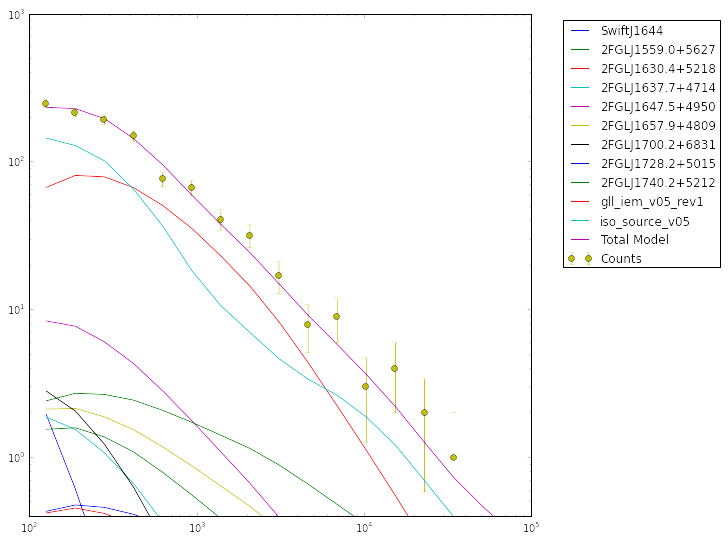

In [22]:
E = (like.energies[:-1] + like.energies[1:])/2.
#The 'energies' array are the endpoints so we take the midpoint of the bins.
plt.figure(figsize=(9,9))
plt.ylim((0.4,1e3))
plt.xlim((100,100000))
sum_model = np.zeros_like(like._srcCnts(like.sourceNames()[0]))
for sourceName in like.sourceNames():
    if sourceName[0] == '_':
        sourceName_lab = sourceName[1:]
    else:
        sourceName_lab = sourceName
    sum_model = sum_model + like._srcCnts(sourceName)
    plt.loglog(E,like._srcCnts(sourceName),label=sourceName_lab)
plt.loglog(E,sum_model,label='Total Model')
plt.errorbar(E,like._Nobs(),yerr=np.sqrt(like._Nobs()), fmt='o',label='Counts')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

We're not detecting any emission from this object (TS = 0.09) so we should really calculate an upper limit.

Upper Limits
------------

There's an upper limit function in the LAT Analysis Scripts but we'll use the raw funation since it's more instructive.

In [23]:
from UpperLimits import UpperLimit

You need to create an UpperLimit object by giving it the likelihood object (called *qL.MIN* in this case) and the source name:

In [24]:
ul = UpperLimit(like, 'SwiftJ1644')

There's a simple upper limit function that we can run. 

In [25]:
ul.compute()

0 0.103996054476 -2.93786797556e-05 1.0490136964e-08
1 0.251419489225 0.0778381564051 2.53608167225e-08
2 0.398842923973 0.289248386032 4.02314964816e-08
3 0.546266358722 0.615635953294 5.51021762574e-08
4 0.69368979347 1.04077990529 6.99728560981e-08
5 0.815313902324 1.46103590634 8.22411442627e-08


(7.914569993457501e-08, 0.78462660081426927)

In [26]:
ul.results

[7.91e-08 ph/cm^2/s for emin=100.0, emax=300000.0, delta(logLike)=1.35]

You can change the limits if you want:

In [27]:
ul.compute(emin=1000.0)

0 0.103996054476 -2.93786797556e-05 1.04456180778e-12
1 0.251419489225 0.0778381564051 2.5253188268e-12
2 0.398842923973 0.289248386032 4.00607580742e-12
3 0.546266358722 0.615635953294 5.48683190654e-12
4 0.69368979347 1.04077990529 6.96758455054e-12
5 0.815313902324 1.46103590634 8.18920465281e-12


(7.88097444449431e-12, 0.78462660081426927)

In [28]:
ul.results

[7.91e-08 ph/cm^2/s for emin=100.0, emax=300000.0, delta(logLike)=1.35,
 7.88e-12 ph/cm^2/s for emin=1000.0, emax=300000.0, delta(logLike)=1.35]

You can also compute a Baysian Upper Limit

In [29]:
ul.bayesianUL()

Setting lower bound on normalization parameter to zero temporarily for upper limit calculation.


(9.462969325975763e-08, 0.93813024107019827)

## And More...

There are some good scripting tools out there:

http://fermi.gsfc.nasa.gov/ssc/data/analysis/user/

It's **very** important that you understand how everything works before you use these.  Black boxes are bad (except when they're good).

## Explore the python tools:

In [30]:
help(like.flux)

Help on method flux in module AnalysisBase:

flux(self, srcName, emin=100, emax=300000.0, energyFlux=False) method of UnbinnedAnalysis.UnbinnedAnalysis instance
    Returns the flux for a source with name "srcName" from emin
    (in MeV) to emax (in MeV).  If "energyFlux=False" it returns
    the integral flux; if True it will return the differential
    flux.



In [31]:
help(ul.compute)

Help on method compute in module UpperLimits:

compute(self, emin=100, emax=300000.0, delta=1.355, tmpfile='temp_model.xml', fix_src_pars=False, verbosity=1, nsigmax=2, npts=5, renorm=False, mindelta=0.01, resample=False) method of UpperLimits.UpperLimit instance



In [32]:
help(ul.bayesianUL)

Help on method bayesianUL in module UpperLimits:

bayesianUL(self, cl=0.95, nsig=10, renorm=False, emin=100, emax=300000.0, npts=50, verbosity=1) method of UpperLimits.UpperLimit instance

